In [289]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, plot_confusion_matrix, plot_roc_curve,precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

### Importando los datos

In [290]:
default = pd.read_csv("Default_Fin.csv")

In [291]:
default.head()

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0


In [292]:
### Shape del dataset
default.shape

(10000, 5)

In [293]:
### Fijando columna Index como índice

default = default.set_index((default["Index"]))

In [294]:
default.head()

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
Index,,,,,
1,1,1,8754.36,532339.56,0
2,2,0,9806.16,145273.56,0
3,3,1,12882.60,381205.68,0
4,4,1,6351.00,428453.88,0
5,5,1,9427.92,461562.00,0


In [295]:
### Eliminando columna Index

default.drop(labels = ["Index"], axis = 1, inplace = True)

In [296]:
default.head()

,Employed,Bank Balance,Annual Salary,Defaulted?
Index,,,,
1,1,8754.36,532339.56,0
2,0,9806.16,145273.56,0
3,1,12882.60,381205.68,0
4,1,6351.00,428453.88,0
5,1,9427.92,461562.00,0


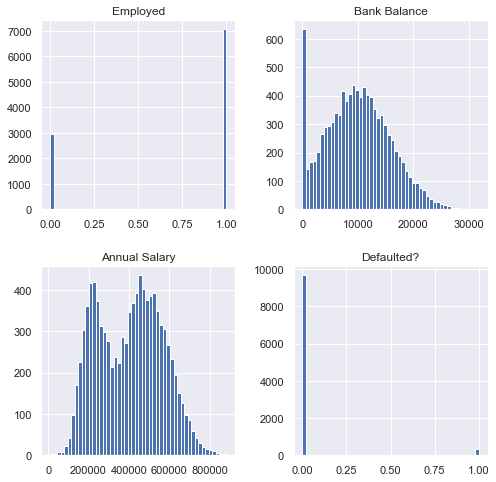

0    9667
1     333
Name: Defaulted?, dtype: int64


In [311]:
rcParams = [8,8]

default.hist(figsize=rcParams, bins=50)
plt.show()
print(default["Defaulted?"].value_counts())
# Distribución de las variables. 
# La variable Defaulted esta imbalanceada.

### Buscando NA's

In [298]:
default.isna().sum()

Employed         0
Bank Balance     0
Annual Salary    0
Defaulted?       0
dtype: int64

### Buscando filas duplicadas

In [299]:
default.duplicated().sum()

0

### Observando la matriz de correlaciones

<AxesSubplot:>

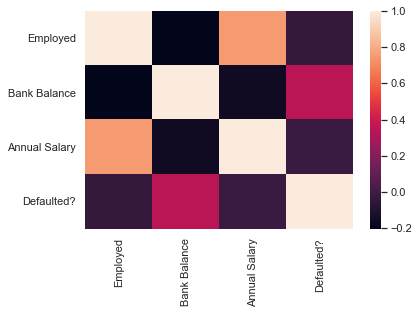

In [300]:
sns.heatmap(default.corr())

### Están fuertemente correlaciandas Annual Salary con Employed

In [301]:
default.groupby(["Defaulted?"]).mean()["Annual Salary"].to_frame()

### Promedio de Salario Anual para los que se les rechaza prestamo contra los que no.
# Tienen Mayor Salario los que se les acepta el préstamo

,Annual Salary
Defaulted?,
0,402793.999321
1,385069.762162


In [302]:
default.groupby(["Defaulted?"]).mean()["Bank Balance"].to_frame()

### Promedio de Balance en el banco para los que se les rechaza prestamo contra los que no.
# Tienen Mayor balance los que se les rechaza el préstamo.

,Bank Balance
Defaulted?,
0,9647.324961
1,20973.858378


### Escalando el dataset

In [303]:
scaler = StandardScaler()
scaler.fit_transform(default)

array([[ 0.64593619, -0.21882757,  0.81318764, -0.18559927],
       [-1.54814054, -0.03761675, -1.60549607, -0.18559927],
       [ 0.64593619,  0.49241197, -0.13121216, -0.18559927],
       ...,
       [ 0.64593619,  0.02074698,  1.8835655 , -0.18559927],
       [ 0.64593619,  1.5167441 ,  0.23636282, -0.18559927],
       [-1.54814054, -1.31169523, -1.24880518, -0.18559927]])

### Separando en conjuntos de testing y prueba

In [304]:
target = "Defaulted?"
columns = [x for x in default.columns.tolist() if x not in target]
X = default[columns]
y = default[target]

In [305]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=.20)

## Regresión Logística

In [306]:
log_reg = LogisticRegression(class_weight="balanced")
params = {"C":[.1,10,100,1000,10000], "penalty": ["none","l2"]}
cv = 5
log_regCV = GridSearchCV(log_reg, params, cv=cv).fit(x_train,y_train)

In [307]:
preds = log_regCV.predict(x_test)
print(log_regCV.best_params_)

{'C': 0.1, 'penalty': 'none'}


In [308]:
print("Recall: ", recall_score(y_test, preds))
print("F1 score: ", f1_score(y_test, preds))
print("Accuracy: ",accuracy_score(y_test, preds))

Recall:  0.8974358974358975
F1 score:  0.17073170731707318
Accuracy:  0.66


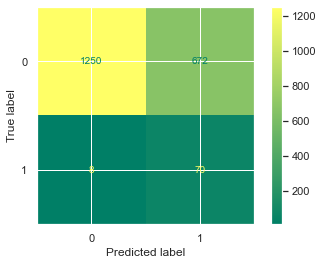

In [309]:
conf = plot_confusion_matrix(log_regCV, x_test, y_test, cmap = "summer")

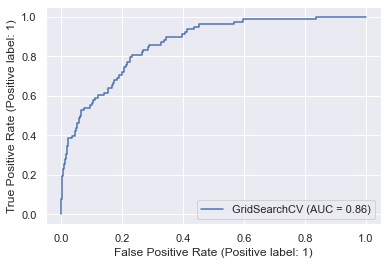

In [310]:
plot_roc_curve(log_regCV, x_test, y_test)

# XGBOOST

In [313]:
xgb = XGBClassifier()
param_grid = {"scale_pos_weights": [20,30,50]}
cv = 5
xgb_CV = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1, scoring="roc_auc")
xgb_CV.fit(x_train,y_train)

[15:10:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [314]:
preds_x = xgb_CV.predict(x_test)
print(xgb_CV.best_params_)

{'scale_pos_weights': 20}


In [315]:
print("Recall: ", recall_score(y_test, preds_x))
print("F1 score: ", f1_score(y_test, preds_x))
print("Accuracy: ",accuracy_score(y_test, preds_x))

Recall:  0.2564102564102564
F1 score:  0.3448275862068965
Accuracy:  0.962


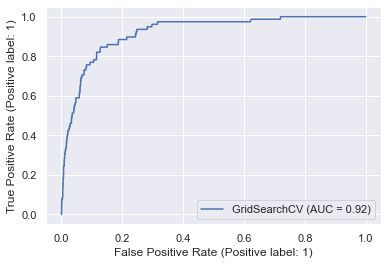

In [316]:
plot_roc_curve(xgb_CV, x_test, y_test)

## Balanceando clases con ADASYN

In [263]:
ada = ADASYN()
x_train, y_train = ada.fit_resample(x_train, y_train)

<AxesSubplot:xlabel='Defaulted?', ylabel='count'>

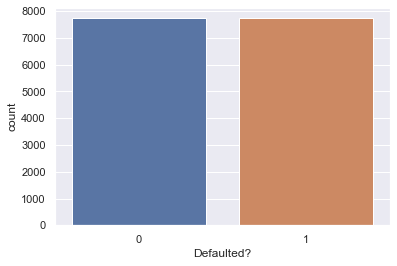

In [264]:
sns.countplot(y_train)

## Árboles de desición

In [267]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
tree = DecisionTreeClassifier()
cv = 5
tree_CV = GridSearchCV(tree, param_grid, cv = cv)
tree_CV.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2']})

In [268]:
preds2 = tree_CV.predict(x_test)
print(tree_CV.best_params_)

{'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto'}


In [269]:
print("Recall: ", recall_score(y_test, preds2))
print("F1 score: ", f1_score(y_test, preds2))
print("Accuracy: ",accuracy_score(y_test, preds2))

Recall:  0.8805970149253731
F1 score:  0.29064039408867
Accuracy:  0.856


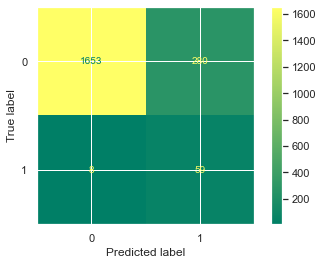

In [270]:
conf = plot_confusion_matrix(tree_CV, x_test, y_test, cmap = "summer")

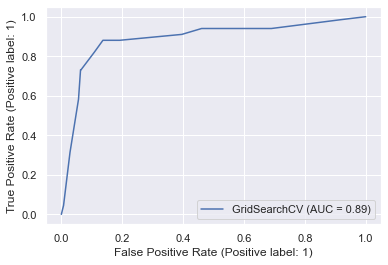

In [271]:
plot_roc_curve(tree_CV, x_test, y_test)

# Random Forests

In [280]:
rf_grid = {'bootstrap': [True, False],
            'max_depth': [10, 20, 30, 40, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': [2, 5],
            'n_estimators': [800, 1000, 1200]}
rf = RandomForestClassifier()
cv = 3
rf_CV = RandomizedSearchCV(estimator= rf, param_distributions=rf_grid, n_iter=50, n_jobs=-1, cv=cv, verbose=2, scoring="roc_auc")
rf_CV.fit(x_train,y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [283]:
print(rf_CV.best_params_)
preds3 = rf_CV.predict(x_test)

{'n_estimators': 1200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [288]:
print("Recall: ", recall_score(y_test, preds3))
print("Precision: ", precision_score(y_test,preds3))
print("F1 score: ", f1_score(y_test, preds3))
print("Accuracy: ",accuracy_score(y_test, preds3))

Recall:  0.8507462686567164
Precision:  0.21839080459770116
F1 score:  0.34756097560975613
Accuracy:  0.893


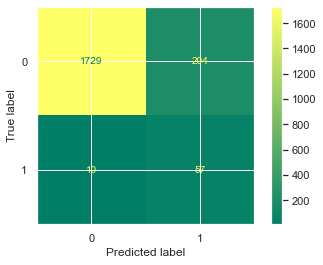

In [285]:
conf = plot_confusion_matrix(rf_CV, x_test, y_test, cmap = "summer")

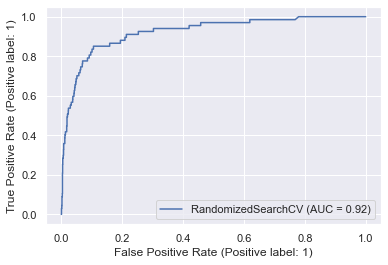

In [286]:
plot_roc_curve(rf_CV, x_test, y_test)